# Example of Convolutional Neural Networks

#### **Import the required libraries**

We will be using a few libraries in this session, import all the required libraries in the cell below one by one as we go through the session.


In [ ]:
import os

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import tqdm
import yaml
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix)
from torchvision import transforms
from torchvision.io import read_image

#### **Download the dataset**

We will be using `CIFAR-10` dataset for this session. The dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. Please download the dataset using the following command.

```python
!wget https://github.com/jahirsadik/cail-workshop-session-1/raw/main/CIFAR-10.zip
!wget https://github.com/jahirsadik/cail-workshop-session-1/raw/main/CNN_config.yaml
!unzip -q CIFAR-10.zip -d .
```


In [ ]:
# Check before downloading CIFAR-10.zip
if not os.path.exists('CIFAR-10.zip'):
    !wget https://github.com/jahirsadik/cail-workshop-session-1/raw/main/CIFAR-10.zip
else:
    print("CIFAR-10.zip already exists. Skipping download.")

# Check before downloading CNN.yaml
if not os.path.exists('CNN_config.yaml'):
    !wget https://github.com/jahirsadik/cail-workshop-session-1/raw/main/CNN_config.yaml
else:
    print("CNN_config.yaml already exists. Skipping download.")

# Check before unzipping CIFAR-10.zip
if os.path.exists('CIFAR-10.zip') and not os.path.exists('CIFAR-10'):
    !unzip -q CIFAR-10.zip -d .
else:
    print("CIFAR-10 directory already exists or zip file is missing. Skipping unzip.")

--2024-10-18 06:28:18--  https://github.com/jahirsadik/cail-workshop-session-1/raw/main/CIFAR-10.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jahirsadik/cail-workshop-session-1/main/CIFAR-10.zip [following]
--2024-10-18 06:28:18--  https://raw.githubusercontent.com/jahirsadik/cail-workshop-session-1/main/CIFAR-10.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57166560 (55M) [application/zip]
Saving to: ‘CIFAR-10.zip’

CIFAR-10.zip        100%[===================>]  54.52M   111MB/s    in 0.5s    

2024-10-18 06:28:19 (111 MB/s) - ‘CIFAR-10.zip’ saved [57166560/57166560]

--2024-1

#### **Load configuration file**

We will be using a configuration file to store all the required parameters for the model. The configuration file is a YAML file, which is a human-readable data serialization standard that can be used in conjunction with all programming languages and is often used to write configuration files. Create a new file named `config.yaml` and add the following content to it.

```yaml
data_params:
  data_path: "CIFAR-10/"
```

Read the configuration file using the `yaml` library and store the data in a variable named `config`.


In [ ]:
file = open("CNN_config.yaml")
config = yaml.safe_load(file)
file.close()
print(config)

{'data_params': {'data_path': 'CIFAR-10/', 'train_ratio': 0.8, 'batch_size': 64}, 'model_params': {'num_classes': 10, 'learning_rate': 0.001, 'weight_decay': 0.0001, 'gamma': 0.1, 'step_size': 5, 'num_epochs': 10}}


#### **Load the dataset**

Check the files in the side panel to see if the dataset is downloaded successfully. The dataset is organized in the following way.

```
CIFAR-10
 |
 └───airplane
 |
 └───automobile
 |
 └───bird
 |
 └───cat
 |
 └───deer
 |
 └───dog
 |
 └───frog
 |
 └───horse
 |
 └───ship
 |
 └───truck
```

Write a class named `CIFAR10Dataset` to load the dataset.


In [ ]:
class CIFAR10(torch.utils.data.Dataset):
    """The CIFAR10 dataset"""

    def __init__(self, root, transform=None, target_transform=None) -> None:
        """
        Initialize the CIFAR10 dataset

        :param root: The root directory of the dataset
        :type root: str
        :param transform: The transform to apply to the data
        :type transform: callable
        :param target_transform: The transform to apply to the target
        :type target_transform: callable

        :return: None
        :rtype: None
        """
        self.root = root
        self.transform = transform
        self.target_transform = target_transform
        self.data = []
        self.targets = []

        self._load_data()

    def _load_data(self):
        """
        Load the data from the root directory

        :return: None
        :rtype: None
        """
        # Load the data
        classes = os.listdir(self.root)
        classes.sort()
        for i, class_name in enumerate(classes):
            class_dir = os.path.join(self.root, class_name)
            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)
                image = read_image(image_path)
                self.data.append(image)
                self.targets.append(float(i))

    def __getitem__(self, index: int) -> tuple:
        """
        Get the item at the given index

        :param index: The index of the item
        :type index: int

        :return: The item at the given index
        :rtype: tuple
        """
        img, target = self.data[index], self.targets[index]

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self) -> int:
        """
        Get the length of the dataset

        :return: The length of the dataset
        :rtype: int
        """
        return len(self.data)

#### **Preprocess transformations**

Insted of loading the entire dataset into memory, and then applying transformations, we will be using `torchvision.transforms` to apply transformations while loading the dataset. We will use the following transformations:

1. `ToTensor`: Convert the image to a tensor with pixel values in the range [0, 1].
2. `Normalize`: Normalize the tensor with mean and standard deviation.
3. `Lambda`: To flatten the image tensor.


In [ ]:
transform = transforms.Compose([
    transforms.ConvertImageDtype(torch.float32),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# you can transform the target too if you want (e.g. one hot encode)
target_transform = transforms.Lambda(
    lambda y: torch.tensor(y, dtype=torch.long))

Initialize the `CIFAR10Dataset` class with the `data_path` from the configuration file or you can use `torchvision.Dataset.ImageFolder` to load the dataset. Pass the transformations to the `CIFAR10Dataset` class and load the dataset.
You can load the class name from the folder using `os.listdir` for later use.


In [ ]:
data_path = config["data_params"]["data_path"]
classes = os.listdir(data_path)
classes.sort()

dataset = CIFAR10(data_path, transform=transform,
                  target_transform=target_transform)

# dataset = ImageFolder(data_path, transform=transform,
#  target_transform=target_transform)

#### **Split the data**

Use `torch.utils.data.random_split` to split the dataset into training and validation sets. Use 80% of the data for training and 10% for validation and 10% for testing.


In [ ]:
train_size = config["data_params"]["train_ratio"]
test_size = (1 - train_size) / 2
val_size = test_size

train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size, val_size])

print(f"Train size: {len(train_dataset)}")
print(f"Test size: {len(test_dataset)}")
print(f"Validation size: {len(val_dataset)}")

Train size: 48001
Test size: 6000
Validation size: 5999


#### **Create data loaders**

Use `torch.utils.data.DataLoader` to create data loaders for training, validation, and testing datasets. Use a batch size from the configuration file.


In [ ]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=config["data_params"]["batch_size"],
    num_workers=torch.get_num_threads(),
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=config["data_params"]["batch_size"],
    num_workers=torch.get_num_threads(),
    shuffle=False
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=config["data_params"]["batch_size"],
    num_workers=torch.get_num_threads(),
    shuffle=True
)

#### **Multi-layer Perceptron (MLP) model**

Create a class named `MLP` to define the model architecture. Now, we will create a simple MLP model with 3 layers. The input layer will have 32x32x3 neurons, the hidden layer will have 128 neurons, and the output layer will have 10 neurons.


In [ ]:
class Cifar10CnnModel(nn.Module):
    """The CIFAR10 CNN model"""

    def __init__(self, output_size: int) -> None:
        """
        Initialize the CIFAR10 CNN model

        :param output_size: The output size
        :type output_size: int
        """
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output: 256 x 4 x 4

            nn.Flatten(),
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, output_size))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass

        :param x: The input data
        :type x: torch.Tensor

        :return: The output
        :rtype: torch.Tensor
        """
        return self.network(x)

#### **Initialize the model**

Initialize the model and define the loss function, optimizer, and scheduler. Use the loss function as `nn.CrossEntropyLoss`, optimizer as `torch.optim.Adam`, and scheduler as `torch.optim.lr_scheduler.StepLR`. Use the learning rate and step size from the configuration file. Use the device as `cuda` if available, else use `cpu`.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Cifar10CnnModel(
    config['model_params']['num_classes']
).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=config["model_params"]["learning_rate"],
    # L2 regularization
    weight_decay=config["model_params"]["weight_decay"]
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=config["model_params"]["step_size"],
    gamma=config["model_params"]["gamma"]
)

##### **Validation function**

Create a function named `validate` to calculate the accuracy of the model on the validation dataset. Use the `model.eval` method to set the model to evaluation mode and use the `torch.no_grad` context manager to disable gradient calculation. Iterate through the validation data loader and calculate the accuracy of the model.


In [ ]:
def validate(
    model,
    val_loader: torch.utils.data.DataLoader,
    criterion: torch.nn.Module,
    device: torch.device
) -> tuple:
    """
    Validate the model

    :param model: The model to validate
    :type model: torch.nn.Module
    :param val_loader: The validation loader
    :type val_loader: torch.utils.data.DataLoader
    :param criterion: The loss function
    :type criterion: torch.nn.Module
    :param device: The device to use
    :type device: torch.device

    :return: The loss, accuracy and predictions
    :rtype: tuple
    """
    model.eval()
    val_loss = 0.0
    correct = 0
    y_pred = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            y_pred.extend(predicted.cpu().numpy())

    val_loss /= len(val_loader)
    accuracy = correct / len(y_pred)

    return val_loss, accuracy, y_pred

#### **Training function**

Write a function named `train` to train the model. Use the `model.train` method to set the model to training mode. Iterate through the training data loader and calculate the loss and accuracy of the model. Use the `optimizer.zero_grad` method to zero the gradients and use the `loss.backward` method to backpropagate the loss. Use the `optimizer.step` method to update the model parameters. Use the `scheduler.step` method to update the learning rate.


In [ ]:
def train(
    model: torch.nn.Module,
    train_loader: torch.utils.data.DataLoader,
    val_loader: torch.utils.data.DataLoader,
    criterion: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler.StepLR,
    device: torch.device,
    num_epochs: int
) -> tuple:
    """
    Train the model

    :param model: The model to train
    :type model: torch.nn.Module
    :param train_loader: The training loader
    :type train_loader: torch.utils.data.DataLoader
    :param val_loader: The validation loader
    :type val_loader: torch.utils.data.DataLoader
    :param criterion: The loss function
    :type criterion: torch.nn.Module
    :param optimizer: The optimizer
    :type optimizer: torch.optim.Optimizer
    :param scheduler: The learning rate scheduler
    :type scheduler: torch.optim.lr_scheduler.StepLR
    :param device: The device to use
    :type device: torch.device
    :param num_epochs: The number of epochs
    :type num_epochs: int

    :return: The trained model and the training history
    :rtype: tuple
    """
    history = {
        "train_loss": [],
        "val_loss": [],
        "val_acc": []
    }
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        loop = tqdm.tqdm(enumerate(train_loader),
                         total=len(train_loader), leave=False)
        for i, (images, labels) in loop:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            loop.set_description(f"Epoch [{epoch + 1}/{num_epochs}]")
            loop.set_postfix(loss=train_loss / (i + 1))

        train_loss /= len(train_loader)
        val_loss, val_acc, _ = validate(model, val_loader, criterion, device)
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch [{epoch + 1}/{num_epochs}]")
        print(f"Train loss: {train_loss:.4f}")
        print(f"Validation loss: {val_loss:.4f}")
        print(f"Validation accuracy: {val_acc:.2f}%")

        if val_acc > best_acc:
            best_acc = val_acc
            checkpoint = {
                "epoch": epoch + 1,
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "history": history
            }
            torch.save(checkpoint, "checkpoint.pth")

        scheduler.step()

    return model, history

##### **Train the model**

Call the `train` function to train the model.


In [ ]:
model, history = train(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    num_epochs=config["model_params"]["num_epochs"]
)

Epoch [2/10]
Train loss: 1.1084
Validation loss: 1.0559
Validation accuracy: 0.63%


Epoch [3/10]
Train loss: 0.8754
Validation loss: 0.9045
Validation accuracy: 0.68%


Epoch [4/10]
Train loss: 0.7414
Validation loss: 0.8652
Validation accuracy: 0.71%


Epoch [5/10]
Train loss: 0.6361
Validation loss: 0.7461
Validation accuracy: 0.74%


Epoch [6/10]
Train loss: 0.4065
Validation loss: 0.6772
Validation accuracy: 0.78%


Epoch [7/10]
Train loss: 0.3420
Validation loss: 0.6971
Validation accuracy: 0.77%


Epoch [8/10]
Train loss: 0.2978
Validation loss: 0.7224
Validation accuracy: 0.77%


Epoch [9/10]
Train loss: 0.2589
Validation loss: 0.7376
Validation accuracy: 0.78%


Epoch [10/10]:  19%|█▊        | 139/751 [00:03<00:14, 41.24it/s, loss=0.221]

#### **Plot the learning curve**

Plot the training loss and validation loss using `matplotlib`, keep both the training loss and validation loss in the same plot.


In [ ]:
plt.plot(history["train_loss"], label="Train loss")
plt.plot(history["val_loss"], label="Validation loss")
plt.title("Loss curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

#### **Load the model from the checkpoint**

Use `torch.load` to load the model from the checkpoint and use the `model.load_state_dict` method to load the model weights.


In [ ]:
model.load_state_dict(torch.load("checkpoint.pth")["model"])

#### **Evaluate model performance**

Now, we have trained the model. Call the `validate` function to validate the model and calculate the loss and predicted labels on the testing data.

1. Use scikit-learn's `classification_report` function to evaluate the performance of the model. The `classification_report` function takes two inputs, `test_labels` and `predicted_labels`, and returns a report of the precision, recall, and F1-score of the model.
2. Use the `confusion_matrix` function to get the confusion matrix of the model. It also takes two inputs, `test_labels` and `predicted_labels`, and returns the confusion matrix of the model. Use `ConfusionMatrixDisplay` to display the confusion matrix.


In [ ]:
_, _, y_pred = validate(model, test_loader, criterion, device)
y_test = [labels for _, labels in test_loader]
y_test = torch.cat(y_test).numpy()

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(
    y_test, y_pred), display_labels=classes)
disp = disp.plot(xticks_rotation=45)
plt.title('Confusion Matrix Test Data')
plt.show()

print('\n\n')
print(classification_report(y_test, y_pred, target_names=classes))

# Discussion of other considerations

**Short example** of hyperparameter tuning using the `RandomizedSearchCV` method from the `scikit-learn` libraryL

- Performs Randomized search on hyper parameters.

- RandomizedSearchCV implements a “fit” and a “score” method.

- The parameters of the estimator used to apply these methods are optimized by cross-validated search over parameter settings.

- In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. The number of parameter settings that are tried is given by n_iter.

- If all parameters are presented as a list, sampling without replacement is performed. If at least one parameter is given as a distribution, sampling with replacement is used. It is highly recommended to use continuous distributions for continuous parameters.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import load_iris

# Load dataset
data = load_iris()
X, y = data.data, data.target

# Define the model
model = RandomForestClassifier()

# Define the hyperparameter grid
param_dist = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Set up the RandomizedSearchCV
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=5, random_state=42, n_jobs=-1)

# Fit the model
random_search.fit(X, y)

# Best parameters found
print(f"Best parameters: {random_search.best_params_}")

**`Optuna`** is a powerful library for hyperparameter optimization. Here's a concise example:

- Define an objective function that Optuna will optimize. This function suggests `hyperparameters` for the `RandomForestClassifier`.

- Load the Iris dataset and splits it into features and labels.

- Use cross-validation to evaluate the model's performance.

- Run the optimization process over a specified number of trials to find the best hyperparameters.

In [ ]:
!pip install optuna # first install optuna

In [ ]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score

# Load dataset
data = load_iris()
X, y = data.data, data.target

# Define the objective function
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    score = cross_val_score(model, X, y, n_jobs=-1, cv=5).mean()
    return score

# Create a study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best parameters
# Print the best parameters and score
print(f"Best parameters: {study.best_params}")
print(f"Best score: {study.best_value:.4f}")


[I 2024-10-12 07:33:28,122] A new study created in memory with name: no-name-5417c135-0c96-455d-8552-bc1f041ad969
[I 2024-10-12 07:33:28,161] Trial 0 finished with value: 0.9533333333333334 and parameters: {'n_estimators': 18, 'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9533333333333334.
[I 2024-10-12 07:33:28,218] Trial 1 finished with value: 0.9533333333333334 and parameters: {'n_estimators': 31, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9533333333333334.
[I 2024-10-12 07:33:28,439] Trial 2 finished with value: 0.96 and parameters: {'n_estimators': 130, 'max_depth': 27, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.96.
[I 2024-10-12 07:33:28,692] Trial 3 finished with value: 0.9666666666666668 and parameters: {'n_estimators': 179, 'max_depth': 28, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 3 with value: 0.9666666666666668.
[I 2024-

Best parameters: {'n_estimators': 179, 'max_depth': 28, 'min_samples_split': 6, 'min_samples_leaf': 1}
Best score: 0.9667


## Visual example of Overfitting and underfitting

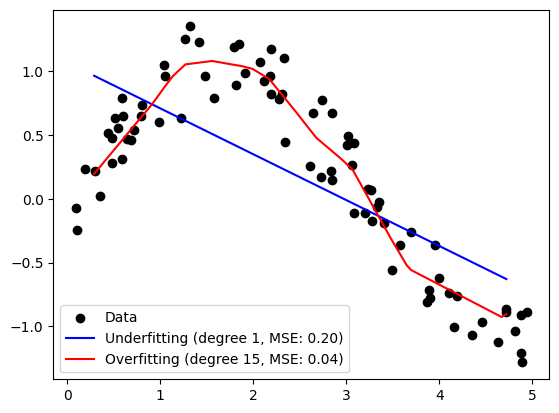

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

# Generate some data
np.random.seed(0)
X = np.sort(5 * np.random.rand(80, 1), axis=0)
y = np.sin(X).ravel() + np.random.normal(0, 0.2, X.shape[0])

# Create test data
X_test = np.sort(5 * np.random.rand(20, 1), axis=0)
y_test = np.sin(X_test).ravel() + np.random.normal(0, 0.2, X_test.shape[0])

# Underfitting: Linear Regression (degree 1)
poly1 = PolynomialFeatures(degree=1)
X_poly1 = poly1.fit_transform(X)
model1 = LinearRegression().fit(X_poly1, y)
y_pred1 = model1.predict(poly1.transform(X_test))
mse1 = mean_squared_error(y_test, y_pred1)

# Overfitting: Polynomial Regression (degree 15)
poly15 = PolynomialFeatures(degree=15)
X_poly15 = poly15.fit_transform(X)
model15 = LinearRegression().fit(X_poly15, y)
y_pred15 = model15.predict(poly15.transform(X_test))
mse15 = mean_squared_error(y_test, y_pred15)

# Plotting
plt.scatter(X, y, color='black', label='Data')
plt.plot(X_test, y_pred1, label=f'Underfitting (degree 1, MSE: {mse1:.2f})', color='blue')
plt.plot(X_test, y_pred15, label=f'Overfitting (degree 15, MSE: {mse15:.2f})', color='red')
plt.legend()
plt.show()


## Data Preprocessing

In [ ]:
# Import necessary libraries
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np

# Load the Iris dataset
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.Series(iris.target)

# Introduce some missing values
np.random.seed(42)
mask = np.random.rand(*X.shape) < 0.1
X[mask] = np.nan

# For demonstration, let's assume the target variable is categorical (though it's numerical in the dataset)
y = y.astype('category')  # Convert target to categorical for one-hot encoding

# Since Iris features are all numerical, let's just handle the target as categorical
numerical_features = X.columns.tolist()  # All features are numerical in Iris
categorical_features = []  # No categorical features in the feature set
target_column = 'target'

# Create a separate imputer to demonstrate its effect
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Build preprocessing pipelines

# Numerical data: Imputation (mean) + Standardization
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Categorical data: OneHotEncoding (for target variable)
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())
])

# Combine transformations
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_features)
])

# Apply preprocessing to features
X_preprocessed = preprocessor.fit_transform(X)

# One-hot encode the target variable
encoder = OneHotEncoder()
y_preprocessed = encoder.fit_transform(y.values.reshape(-1, 1)).toarray()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y_preprocessed, test_size=0.2, random_state=42)

# Print statements to visualize the processed data
print("Original data shape:", X.shape)
print("Preprocessed data shape:", X_preprocessed.shape)
print("\nFirst 5 rows of original data (with missing values):")
print(X.head())

print("\nFirst 5 rows of imputed data (before scaling):")
print(X_imputed.head())

# Highlight the differences
print("\nDifferences between original and imputed data:")
for column in X.columns:
    mask = X[column].isna()
    if mask.any():
        print(f"\nColumn: {column}")
        print("Original (with NaN) vs Imputed:")
        comparison = pd.DataFrame({
            'Original': X[column],
            'Imputed': X_imputed[column]
        })
        print(comparison[mask].head())

print("\nOriginal target shape:", y.shape)
print("Preprocessed target shape:", y_preprocessed.shape)
print("\nFirst 5 values of original target:")
print(y.head())
print("\nFirst 5 rows of preprocessed target:")
print(y_preprocessed[:5])

print("\nTraining data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)
print("Training target shape:", y_train.shape)
print("Testing target shape:", y_test.shape)

Original data shape: (150, 4)
Preprocessed data shape: (150, 4)

First 5 rows of original data (with missing values):
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                NaN               0.2
2                4.7               3.2                NaN               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2

First 5 rows of imputed data (before scaling):
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5           1.400000               0.2
1                4.9               3.0           3.737879               0.2
2                4.7               3.2           3.737879               0.2
3                4.6               3.1           1.500000               0.

## Example of data augmentation

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load the Iris dataset
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.Series(iris.target)

# Convert target to categorical for one-hot encoding
y = y.astype('category')

# Define numerical and categorical features
numerical_features = X.columns.tolist()
categorical_features = []

# Preprocessing pipelines for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Combine preprocessing
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_features)
])

# Preprocess the data
X_preprocessed = preprocessor.fit_transform(X)

# One-hot encode the target variable (as we would need it for neural networks)
encoder = OneHotEncoder()
y_preprocessed = encoder.fit_transform(y.values.reshape(-1, 1)).toarray()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y_preprocessed, test_size=0.2, random_state=42)

# Data Augmentation Function (as shown earlier)
def augment_data(X, augmentation_factor=2):
    augmented_data = []

    for _ in range(augmentation_factor):  # How many times to augment each sample

        # Noise Addition (Gaussian noise)
        noise = np.random.normal(0, 0.1, X.shape)  # Mean=0, Std=0.1
        augmented_data.append(X + noise)

        # Scaling (random scaling between 0.9 and 1.1)
        scale_factor = np.random.uniform(0.9, 1.1)
        augmented_data.append(X * scale_factor)

        # Shifting (random shifts between -0.1 and 0.1)
        shifts = np.random.uniform(-0.1, 0.1, X.shape)
        augmented_data.append(X + shifts)

        # Rotation (simulating rotation of features)
        rotation_factor = np.random.uniform(-0.1, 0.1)
        rotation_matrix = np.eye(X.shape[1]) + np.random.uniform(-rotation_factor, rotation_factor, (X.shape[1], X.shape[1]))
        rotated_data = np.dot(X, rotation_matrix)
        augmented_data.append(rotated_data)

        # Cropping (simulating cropping by zeroing out random features)
        crop_mask = np.random.choice([0, 1], size=X.shape, p=[0.2, 0.8])  # 20% chance of zeroing out a feature
        cropped_data = X * crop_mask
        augmented_data.append(cropped_data)

    # Concatenate the original data with augmented data
    augmented_data = np.concatenate(augmented_data, axis=0)
    return augmented_data

# Apply augmentation to the training set
X_train_augmented = augment_data(X_train, augmentation_factor=2)

# Replicate labels to match the augmented data
y_train_augmented = np.tile(y_train, (5 * 2, 1))  # 5 augmentations, factor 2

# Final shapes after augmentation
print(f"Original X_train shape: {X_train.shape}")
print(f"Augmented X_train shape: {X_train_augmented.shape}")
print(f"Original y_train shape: {y_train.shape}")
print(f"Augmented y_train shape: {y_train_augmented.shape}")

Original X_train shape: (120, 4)
Augmented X_train shape: (1200, 4)
Original y_train shape: (120, 3)
Augmented y_train shape: (1200, 3)


## Explainability

In [ ]:
!pip install shap
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 5.1 MB/s eta 0:00:00


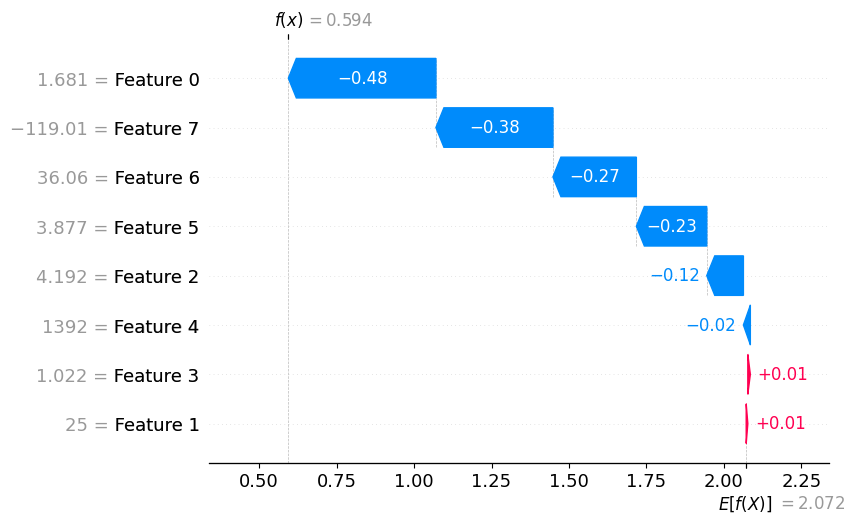

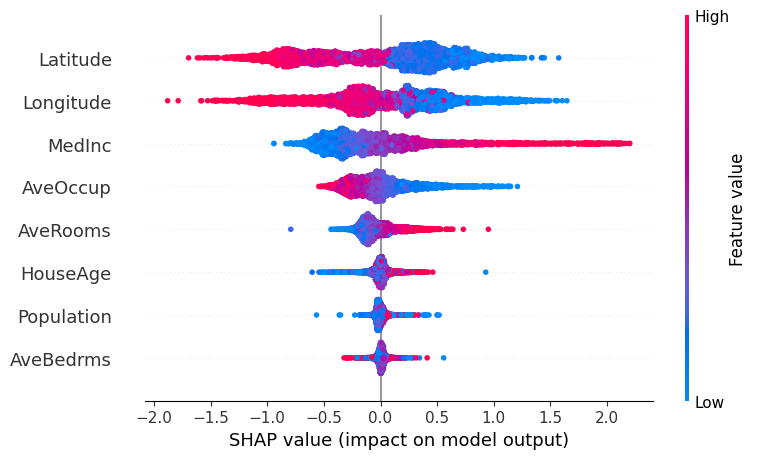

In [ ]:
import shap
import xgboost
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

# Load dataset
housing = fetch_california_housing()
X, y = housing.data, housing.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = xgboost.XGBRegressor().fit(X_train, y_train)

# Explain model predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Visualize the first prediction's explanation
shap.initjs()
shap.plots.waterfall(shap_values[0])

# Summary plot
shap.summary_plot(shap_values, X_test, feature_names=housing.feature_names)

### Overview

The SHAP (SHapley Additive exPlanations) summary plot provides a visual representation of the features that have the most significant impact on the model's predictions. Each dot represents a data point, and its position on the x-axis indicates the feature's contribution to the prediction. The color of the dot corresponds to the value of the feature.

### Key Observations from the Plot:

**Feature Importance:**

- Latitude and Longitude: These features appear to be the most influential factors in the model's predictions. This suggests that geographical location plays a significant role in the outcome.
- MedInc: Median income also seems to be a relatively important factor.
- AveOccup, AveRooms, HouseAge, Population, and AveBedrms: These features have a lower impact on the model's predictions compared to the top three.

**Feature Interactions:**
The overlapping dots indicate that there might be interactions between features. For example, the impact of AveRooms might depend on the values of HouseAge or Population.

**Feature Effects:**
The colors of the dots suggest that higher values of Latitude and Longitude tend to have a positive impact on the prediction, while higher values of MedInc might have a negative impact. However, the exact relationship between these features and the prediction can be more complex and might depend on specific combinations of feature values.

## Strategies for Efficient Resource Management

### Efficient Memory Use with Batch Processing:

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the data
x_train, x_test = x_train / 255.0, x_test / 255.0

# Create a simple model
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model using batch processing
model.fit(x_train, y_train, epochs=5, batch_size=64)


Epoch 1/5
938/938 [==============================] - 4s 3ms/step - loss: 0.3315 - accuracy: 0.9046
Epoch 2/5
938/938 [==============================] - 3s 3ms/step - loss: 0.1594 - accuracy: 0.9534
Epoch 3/5
938/938 [==============================] - 3s 3ms/step - loss: 0.1175 - accuracy: 0.9662
Epoch 4/5
938/938 [==============================] - 3s 3ms/step - loss: 0.0962 - accuracy: 0.9708
Epoch 5/5
938/938 [==============================] - 3s 3ms/step - loss: 0.0822 - accuracy: 0.9750


In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the data
x_train, x_test = x_train / 255.0, x_test / 255.0

# Create a simple model
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model using batch processing
model.fit(x_train, y_train, epochs=5, batch_size=8)

Epoch 1/5
7500/7500 [==============================] - 19s 2ms/step - loss: 0.2474 - accuracy: 0.9265
Epoch 2/5
7500/7500 [==============================] - 17s 2ms/step - loss: 0.1285 - accuracy: 0.9601
Epoch 3/5
7500/7500 [==============================] - 16s 2ms/step - loss: 0.1025 - accuracy: 0.9683
Epoch 4/5
7500/7500 [==============================] - 16s 2ms/step - loss: 0.0871 - accuracy: 0.9737
Epoch 5/5
7500/7500 [==============================] - 16s 2ms/step - loss: 0.0779 - accuracy: 0.9751


## Optimizing GPU/CPU Utilization:

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import time

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

# Define a simple neural network
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Function to train model on a specific device and measure time
def train_model(device):
    model = SimpleNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    start_time = time.time()

    for epoch in range(2):  # Reduced epochs for quick demo
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

    elapsed_time = time.time() - start_time
    print(f'Training on {device}: {elapsed_time:.2f} seconds')

# Train and compare performance
train_model(torch.device("cpu"))
if torch.cuda.is_available():
    train_model(torch.device("cuda"))
else:
    print("GPU not available")


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 9922234.70it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 511978.69it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3773048.03it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9534799.18it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Training on cpu: 46.18 seconds
Training on cuda: 19.20 seconds
